In [36]:
import pandas as pd
import numpy as np
import prince

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
marketing = pd.read_csv("marketing_campaign.csv", encoding="utf-8", sep= "\t")

## Pré traitement des données

In [3]:
marketing.drop(['Z_CostContact','Z_Revenue'], axis=1, inplace=True)

In [4]:
marketing.fillna({'Income': marketing['Income'].median()}, inplace=True)

In [5]:
marketing['Education'] = marketing['Education'].astype('category')
marketing['Marital_Status'] = marketing['Marital_Status'].astype('category')
marketing['Kidhome'] = marketing['Kidhome'].astype('category')
marketing['Teenhome'] = marketing['Teenhome'].astype('category')
marketing['Dt_Customer'] = pd.to_datetime(marketing['Dt_Customer'], format='%d-%m-%Y')

In [6]:
marketing['AcceptedCmp1'] = marketing['AcceptedCmp1'].astype('category')
marketing['AcceptedCmp1'] = marketing['AcceptedCmp1'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['AcceptedCmp2'] = marketing['AcceptedCmp2'].astype('category')
marketing['AcceptedCmp2'] = marketing['AcceptedCmp2'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['AcceptedCmp3'] = marketing['AcceptedCmp3'].astype('category')
marketing['AcceptedCmp3'] = marketing['AcceptedCmp3'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['AcceptedCmp4'] = marketing['AcceptedCmp4'].astype('category')
marketing['AcceptedCmp4'] = marketing['AcceptedCmp4'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['AcceptedCmp5'] = marketing['AcceptedCmp5'].astype('category')
marketing['AcceptedCmp5'] = marketing['AcceptedCmp5'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['Complain'] = marketing['Complain'].astype('category')
marketing['Complain'] = marketing['Complain'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['Response'] = marketing['Response'].astype('category')
marketing['Response'] = marketing['Response'].cat.rename_categories({0: 'No', 1:'Yes'})

In [7]:
marketing = marketing.drop(marketing[marketing['ID'] == 9432].index)

In [8]:
vieux = marketing.loc[marketing['Year_Birth'] < 1920, 'ID']
for i in vieux: 
    marketing = marketing.drop(marketing[marketing['ID'] == i].index)

In [9]:
marketing["Age_Categorie"] = pd.cut(
    2015 - marketing["Year_Birth"],
    bins=[18, 30, 45, 60, float('inf')],
    labels=["Age_18-30", "Age_30-45", "Age_45-60", "Age_>60"],
    right=True
)

In [10]:
viandards = marketing.loc[marketing['MntMeatProducts'] > 1500, 'ID']
for i in viandards: 
    marketing = marketing.drop(marketing[marketing['ID'] == i].index)

In [11]:
gourmands = marketing.loc[marketing['MntSweetProducts'] > 225, 'ID']
for i in gourmands: 
    marketing = marketing.drop(marketing[marketing['ID'] == i].index)

In [12]:
marketing['Depense_Total']= marketing[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
marketing['Total_Achat'] = marketing[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

In [13]:
date_reference = pd.to_datetime('2015-01-01')

marketing['Anciennete_jours'] = (date_reference - marketing['Dt_Customer']).dt.days

marketing['Anciennete_mois'] = (marketing['Anciennete_jours'] / 30.44).round(1)

In [14]:
marketing['Marital_Status'] = marketing['Marital_Status'].replace({
    'YOLO': None,
    'Absurd': None,
    'Married': 'Couple',
    'Together': 'Couple',
    'Single': 'Seul',
    'Alone': 'Seul',
    'Widow': 'Seul',
    'Divorced': 'Divorcé'
})

/tmp/ipykernel_1092/2065117912.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  marketing['Marital_Status'] = marketing['Marital_Status'].replace({


In [15]:
marketing['Total_Enfants'] = marketing['Kidhome'].astype(int) + marketing['Teenhome'].astype(int)
marketing['Total_Enfants'] = marketing['Total_Enfants'].astype('category')
marketing.drop(['Kidhome', 'Teenhome'], axis=1, inplace=True)

In [16]:
marketing['Niveau_Etude'] = marketing['Education'].replace({
    'Graduation': 'Moyen',
    'PhD': 'Eleve',
    'Master': 'Eleve',
    '2n Cycle': 'Faible',
    'Basic': 'Moyen',
})
marketing.drop(['Education'], axis=1, inplace=True)

/tmp/ipykernel_1092/501913221.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  marketing['Niveau_Etude'] = marketing['Education'].replace({


In [17]:
marketing['Nbr_Cmp'] = marketing[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].apply(lambda x: x.cat.codes).sum(axis=1)

In [18]:
marketing.head()

,ID,Year_Birth,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Complain,Response,Age_Categorie,Depense_Total,Total_Achat,Anciennete_jours,Anciennete_mois,Total_Enfants,Niveau_Etude,Nbr_Cmp
0,5524,1957,Seul,58138.0,2012-09-04,58,635,88,546,172,...,No,Yes,Age_45-60,1617,22,849,27.9,0,Moyen,1
1,2174,1954,Seul,46344.0,2014-03-08,38,11,1,6,2,...,No,No,Age_>60,27,4,299,9.8,2,Moyen,0
2,4141,1965,Couple,71613.0,2013-08-21,26,426,49,127,111,...,No,No,Age_45-60,776,20,498,16.4,0,Moyen,0
3,6182,1984,Couple,26646.0,2014-02-10,26,11,4,20,10,...,No,No,Age_30-45,53,6,325,10.7,1,Moyen,0
4,5324,1981,Couple,58293.0,2014-01-19,94,173,43,118,46,...,No,No,Age_30-45,422,14,347,11.4,1,Eleve,0


In [19]:
marketing.columns

Index(['ID', 'Year_Birth', 'Marital_Status', 'Income', 'Dt_Customer',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age_Categorie', 'Depense_Total', 'Total_Achat',
       'Anciennete_jours', 'Anciennete_mois', 'Total_Enfants', 'Niveau_Etude',
       'Nbr_Cmp'],
      dtype='object')

## Application de la NMF

In [42]:
# on garde que les variables quanti (et positives mais ici elles l'étaient dèjà toutes). On fait aussi un peu le tri pour
# ne pas avoir de variables redondantes.

features_nmf = [
    'Income', 'Recency','MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
    'NumStorePurchases', 'NumWebVisitsMonth', 'Depense_Total',
    'Total_Achat', 'Anciennete_mois', 'Nbr_Cmp'
]

In [43]:
# on normalise les données

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(marketing[features_nmf])

In [44]:
# on applique la NMF

from sklearn.decomposition import NMF

# on choisit arbitrairement un nombre de composants pour commencer

nmf = NMF(n_components=3, random_state=0)
W = nmf.fit_transform(X_scaled)  # Matrice des clients x composantes
H = nmf.components_              # Matrice des composantes x variables

In [75]:
components = pd.DataFrame(H, columns=features_nmf)
components.T.sort_values(by=0, ascending=False)

,0,1,2
NumStorePurchases,3.810807,1.153691,0.801093
Total_Achat,3.743306,0.956510,0.537588
Depense_Total,3.721445,0.108445,0.000000
NumCatalogPurchases,3.628535,0.002498,0.138381
MntWines,2.962538,0.266238,0.000000
MntMeatProducts,2.844225,0.000000,0.000000
Income,2.423184,0.594475,0.822266
MntFishProducts,2.412242,0.000000,0.000000
MntSweetProducts,2.265342,0.000000,0.000000
MntFruits,2.195099,0.000000,0.000000


In [76]:
components = pd.DataFrame(W)
components.head(15)

,0,1,2
0,0.156979,0.143881,0.080903
1,0.008747,0.050055,0.087456
2,0.100148,0.100136,0.055222
3,0.012334,0.068411,0.064104
4,0.058241,0.055305,0.195833
5,0.094356,0.106375,0.039927
6,0.072342,0.179675,0.063686
7,0.011901,0.147711,0.070664
8,0.001262,0.139750,0.044376
9,0.000000,0.077278,0.150200


In [49]:
# On a ici une représentation des composantes latentes de la NMF. On a réduit nos données en 4 composantes latentes.
# On voit que le poids des achats et dépenses en tout genre est le plus fort dans la composante 0, avec la salaire en plus.
# On peut assimiler cette composante latente au pouvoir d'achat.
# La 1 est surtout influencée par l'ancienneté.
# La 2 par le nombre de jours depuis le dernier achat

In [50]:
# on peut faire un sorte de clustering sans vraiment en faire un. On va ajouter une variable à chaque client qui est sa
# composante dominante dans la NMF. Ainsi, on peut dresser des profils.

marketing['Profil_NMF'] = np.argmax(W, axis=1)

In [51]:
# on peut afficher la moyenne de chaque profil

W_profiles = marketing.groupby('Profil_NMF')[features_nmf].mean()

print(W_profiles)

                  Income    Recency    MntWines  MntFruits  MntMeatProducts  \
Profil_NMF                                                                    
0           75704.190949  39.810155  639.554084  67.211921       442.860927   
1           44444.292806  35.537994  238.494428  16.462006        88.847011   
2           47289.472117  71.557668  196.193916  15.252218        97.338403   

            MntFishProducts  MntSweetProducts  MntGoldProds  \
Profil_NMF                                                    
0                 97.913907         68.947020     78.593819   
1                 22.876393         15.955420     39.339412   
2                 21.495564         16.520913     29.811153   

            NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
Profil_NMF                                                            
0                    1.362031         5.344371             6.008830   
1                    2.926039         4.072948             1.733536   
2   

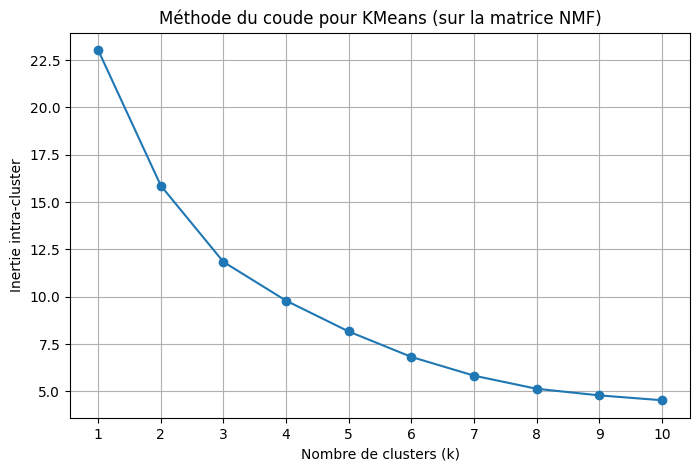

In [52]:
# on peut aussi effectuer un clustering sur la matrice W de la NMF. 

# on commence par une méthode du coude

inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(W)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.title("Méthode du coude pour KMeans (sur la matrice NMF)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [84]:
# on effectue le clustering

kmeans = KMeans(n_clusters=3, random_state=0)

marketing['Cluster_NMF'] = kmeans.fit_predict(W)

In [85]:
# on peut afficher la moyenne de chaque cluster

cluster_profiles = marketing.groupby('Cluster_NMF')[features_nmf].mean()

print(cluster_profiles)

                   Income    Recency    MntWines  MntFruits  MntMeatProducts  \
Cluster_NMF                                                                    
0            43439.914573  38.571608  237.275126  14.855528        82.795226   
1            73689.207519  45.302256  617.060150  60.860150       398.335338   
2            41523.976562  63.463542  105.069010   8.375000        44.674479   

             MntFishProducts  MntSweetProducts  MntGoldProds  \
Cluster_NMF                                                    
0                  19.564070         14.248744     41.045226   
1                  89.930827         62.809023     74.816541   
2                  11.089844          8.992188     20.217448   

             NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
Cluster_NMF                                                            
0                     3.136935         4.208543             1.646985   
1                     1.581955         5.448120             5.

In [86]:
# On remarque 3 groupes différents:

# Cluster 0 : revenus peu élevés, mais visitent le plus le site et ahcètent plus que le Cluster 2 qui a les mêmes revenus. Profitent
# des promotions. Sont les plus anciens. -> LES FIDELES

# Cluster 1 : revenus les plus élevés, achètent le plus de chaque produit, profitent peu des promotions, achètent beacoup en catalogue
# et en magasin. Visitent peu le site web. -> LES CHERCHEURS DE QUALITE

# Cluster 2 : revenus les plus faibles, peu de dépenses malgré une fréquence élevée de visites du site. Sont les clients les plus récents.
# -> LES FRILEUX

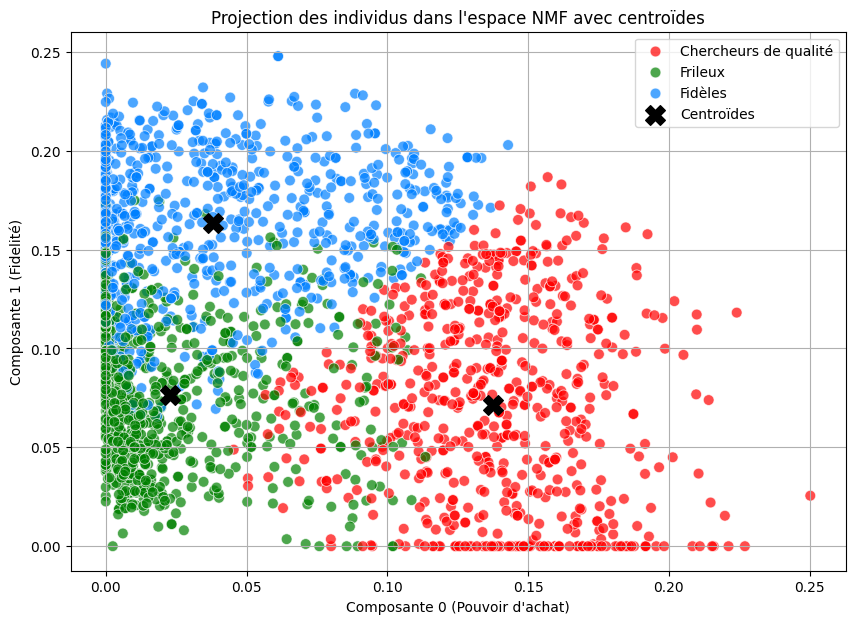

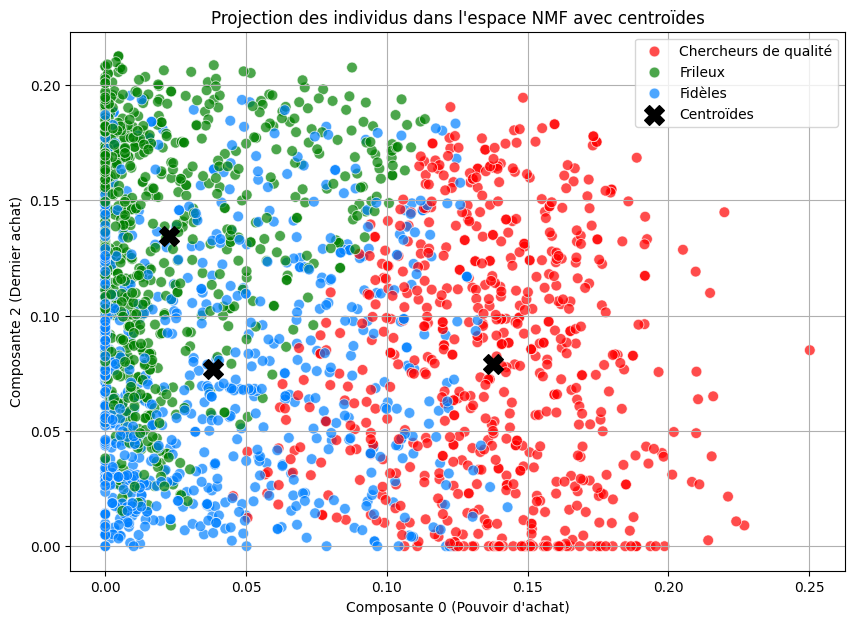

In [87]:
# on plot le graphe des individus selon les composantes de W

cluster_names = {
    0: "Fidèles",
    1: "Chercheurs de qualité",
    2: "Frileux"
}

df_plot = pd.DataFrame({
    'Composante 0': W[:, 0],
    'Composante 1': W[:, 1],
    'Composante 2': W[:, 2],
    'Cluster': marketing['Cluster_NMF'].astype(str)
})

df_plot['Cluster'] = marketing['Cluster_NMF'].map(cluster_names)

custom_palette = {
    "Fidèles": "#0080FF",  # bleu
    "Chercheurs de qualité": "#FF0000",   # rouge
    "Frileux": "#008000"     # vert
}

centroids = kmeans.cluster_centers_

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x='Composante 0', y='Composante 1', hue='Cluster', palette=custom_palette, s=60, alpha=0.7)

plt.scatter(centroids[:, 0], centroids[:, 1],
            c='black', s=200, marker='X', label='Centroïdes')

plt.title("Projection des individus dans l'espace NMF avec centroïdes")
plt.xlabel("Composante 0 (Pouvoir d'achat)")
plt.ylabel("Composante 1 (Fidelité)")
plt.legend()
plt.grid(True)
plt.show()

palette = ["#E63946", "#457B9D", "#2A9D8F"]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x='Composante 0', y='Composante 2', hue='Cluster', palette=custom_palette, s=60, alpha=0.7)

plt.scatter(centroids[:, 0], centroids[:, 2],
            c='black', s=200, marker='X', label='Centroïdes')

plt.title("Projection des individus dans l'espace NMF avec centroïdes")
plt.xlabel("Composante 0 (Pouvoir d'achat)")
plt.ylabel("Composante 2 (Dernier achat)")
plt.legend()
plt.grid(True)
plt.show()